In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from IPython.display import Math
import datetime
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [17]:
df = pd.read_csv('G:/My Drive/eo_pivot_2.csv')
df_temp = pd.read_csv('G:/My Drive/eo_pivot.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             172 non-null    object 
 1   display_S        172 non-null    float64
 2   b_branded_S      172 non-null    float64
 3   b_category_S     172 non-null    float64
 4   b_competitive_S  172 non-null    int64  
 5   p_auto_S         172 non-null    float64
 6   p_brand_S        172 non-null    float64
 7   p_category_S     172 non-null    float64
 8   p_competitive_S  172 non-null    float64
 9   revenue          172 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 13.6+ KB


In [25]:
print('Missing Values')
print(df_temp.isnull().sum() / len(df) * 100)
print('Zeroes')
print((df_temp == 0).sum())

Missing Values
DATE               0.0
display_S          0.0
display_I          0.0
b_branded_S        0.0
b_branded_I        0.0
b_category_S       0.0
b_category_I       0.0
b_competitive_S    0.0
b_competitive_I    0.0
p_auto_S           0.0
p_auto_I           0.0
p_brand_S          0.0
p_brand_I          0.0
p_category_S       0.0
p_category_I       0.0
p_competitive_S    0.0
p_competitive_I    0.0
revenue            0.0
dtype: float64
Zeroes
DATE                 0
display_S           46
display_I           46
b_branded_S         12
b_branded_I         11
b_category_S        32
b_category_I        32
b_competitive_S    182
b_competitive_I    182
p_auto_S            37
p_auto_I            36
p_brand_S           10
p_brand_I           10
p_category_S        10
p_category_I        10
p_competitive_S     10
p_competitive_I     10
revenue              0
dtype: int64


Initially we have over half missing, as well as a few zeroes which can be problematic during forecasting. I'll drop the zeroes since they make up a small part of the dataset.

In [ ]:
# df = df[df.y != 0]

In [ ]:
# print('Missing Values')
# print(df['y'].isnull().sum() / len(df) * 100)
# print('Zeroes')
# print((df['y'] == 0).sum())

In [15]:
df.nunique()

DATE               172
display_S          127
b_branded_S        171
b_category_S       151
b_competitive_S      1
p_auto_S           144
p_brand_S          172
p_category_S       172
p_competitive_S    172
revenue            172
dtype: int64

In [16]:
df.describe()

,display_S,b_branded_S,b_category_S,b_competitive_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue
count,172.000000,172.000000,172.000000,172.0,172.000000,172.000000,172.000000,172.000000,172.000000
mean,4401.456395,464.768547,1967.342326,0.0,2927.935349,2584.759186,13787.436512,1556.526047,95278.449302
std,4615.438261,646.838552,1869.274951,0.0,2882.351080,2023.343047,6899.716980,1548.531411,27984.974843
min,0.000000,0.000000,0.000000,0.0,0.000000,158.130000,1625.880000,34.810000,32134.510000
25%,0.000000,116.280000,488.947500,0.0,312.447500,1110.750000,9331.922500,346.525000,76007.087500
50%,3758.330000,298.135000,1244.580000,0.0,2055.200000,1789.010000,12251.535000,1170.170000,93945.470000
75%,5527.582500,470.962500,3107.095000,0.0,5015.460000,4060.507500,17062.922500,2192.205000,109930.700000
max,24634.650000,4209.840000,8287.340000,0.0,12808.270000,8513.440000,49020.900000,6163.160000,174302.250000


,display_S,display_I,b_branded_S,b_branded_I,b_category_S,b_category_I,b_competitive_S,b_competitive_I,p_auto_S,p_auto_I,p_brand_S,p_brand_I,p_category_S,p_category_I,p_competitive_S,p_competitive_I,revenue
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,0.0,0.0,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.102667,-0.026667,0.335333,0.320000,0.163333,0.206000,NaN,NaN,0.458667,0.471333,0.443333,0.441333,0.525333,0.488667,0.485333,0.421333,0.465333
std,0.414513,0.459296,0.393662,0.394806,0.352636,0.361224,NaN,NaN,0.437833,0.425657,0.357604,0.388585,0.249195,0.364336,0.390107,0.415226,0.258647
min,-0.400000,-0.490000,-0.490000,-0.490000,-0.250000,-0.220000,NaN,NaN,-0.430000,-0.360000,-0.220000,-0.170000,-0.040000,-0.240000,-0.230000,-0.290000,0.020000
25%,-0.170000,-0.325000,0.225000,0.210000,-0.120000,-0.050000,NaN,NaN,0.255000,0.235000,0.215000,0.145000,0.470000,0.370000,0.200000,0.170000,0.270000
50%,0.000000,-0.130000,0.360000,0.350000,0.210000,0.090000,NaN,NaN,0.620000,0.650000,0.510000,0.660000,0.540000,0.500000,0.640000,0.510000,0.450000
75%,0.230000,0.105000,0.495000,0.490000,0.300000,0.465000,NaN,NaN,0.740000,0.765000,0.670000,0.710000,0.645000,0.755000,0.765000,0.745000,0.620000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


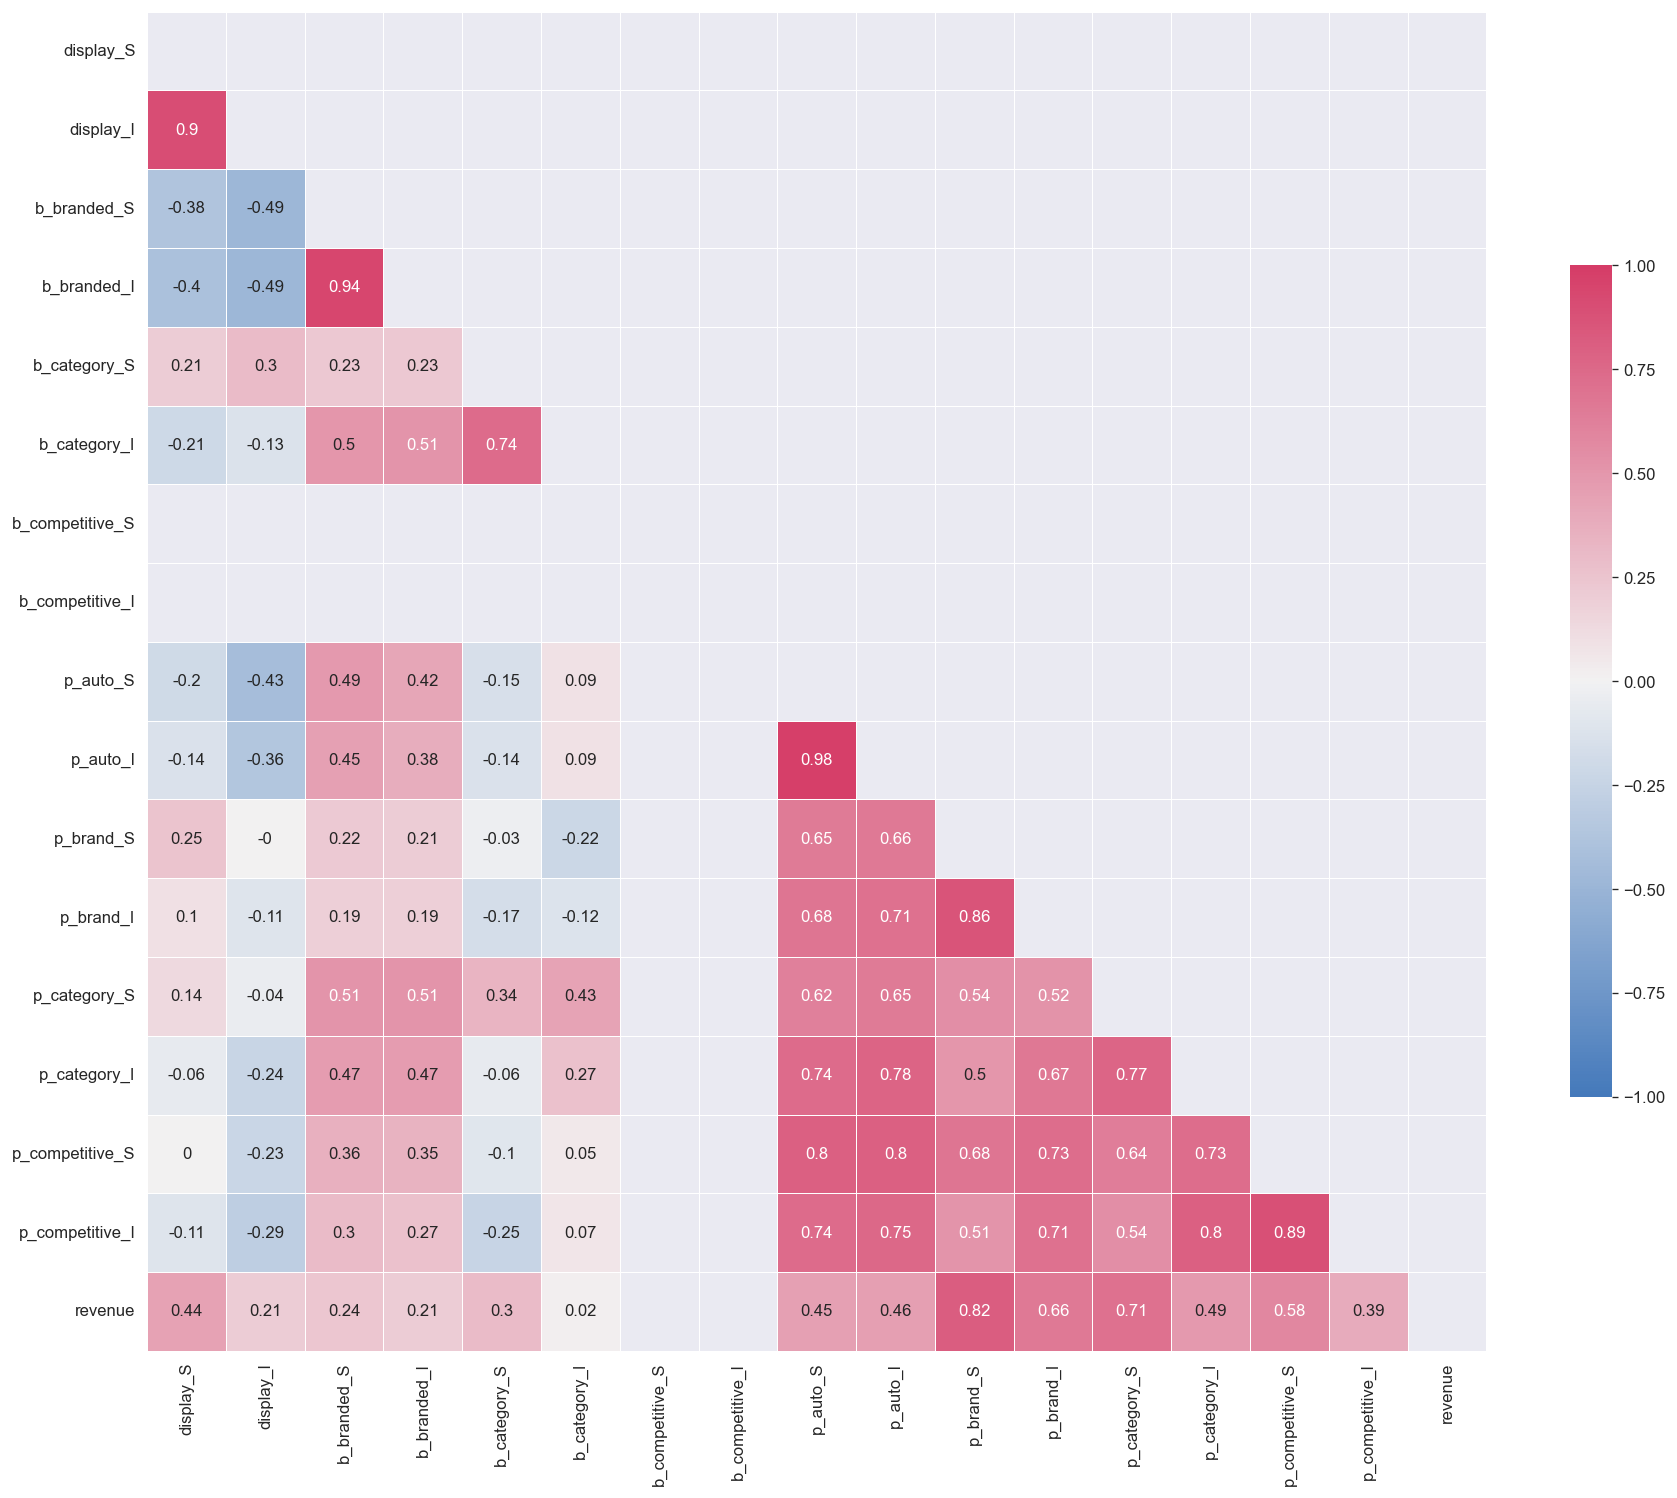

In [18]:
corr = df_temp.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

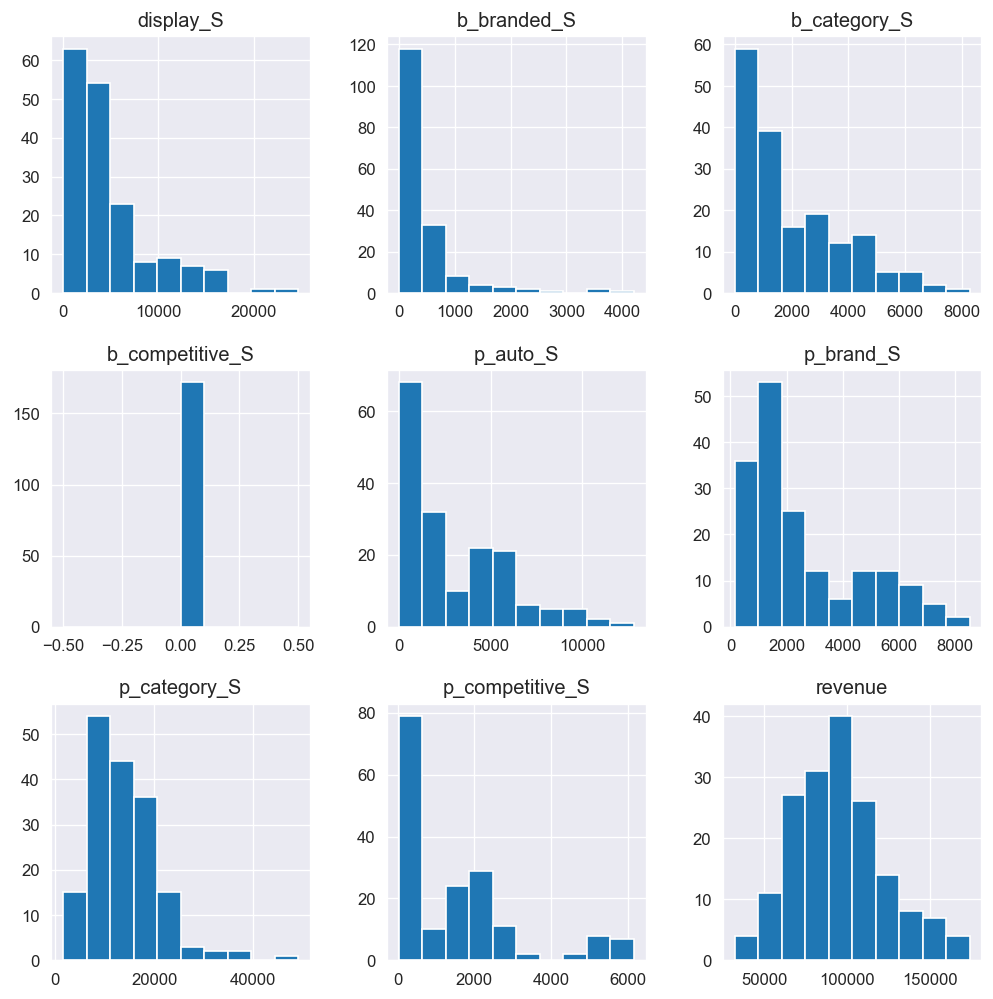

In [35]:
ax = df.hist(grid=True, figsize=(10,10))
ax.set_xlabel("Session Duration (Seconds)")

,display_S,b_branded_S,b_category_S,b_competitive_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue
count,8.000000,8.00000,8.000000,0.0,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.225000,0.24875,0.137500,NaN,0.401250,0.463750,0.517500,0.438750,0.517500
std,0.427417,0.39426,0.418526,NaN,0.448153,0.377887,0.251325,0.410311,0.299464
min,-0.380000,-0.38000,-0.300000,NaN,-0.300000,-0.170000,0.200000,-0.260000,0.100000
25%,-0.017500,0.09750,-0.192500,NaN,0.222500,0.262500,0.385000,0.190000,0.320000
50%,0.240000,0.17000,0.150000,NaN,0.485000,0.525000,0.510000,0.540000,0.515000
75%,0.372500,0.41500,0.257500,NaN,0.637500,0.670000,0.600000,0.667500,0.692500
max,1.000000,1.00000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000


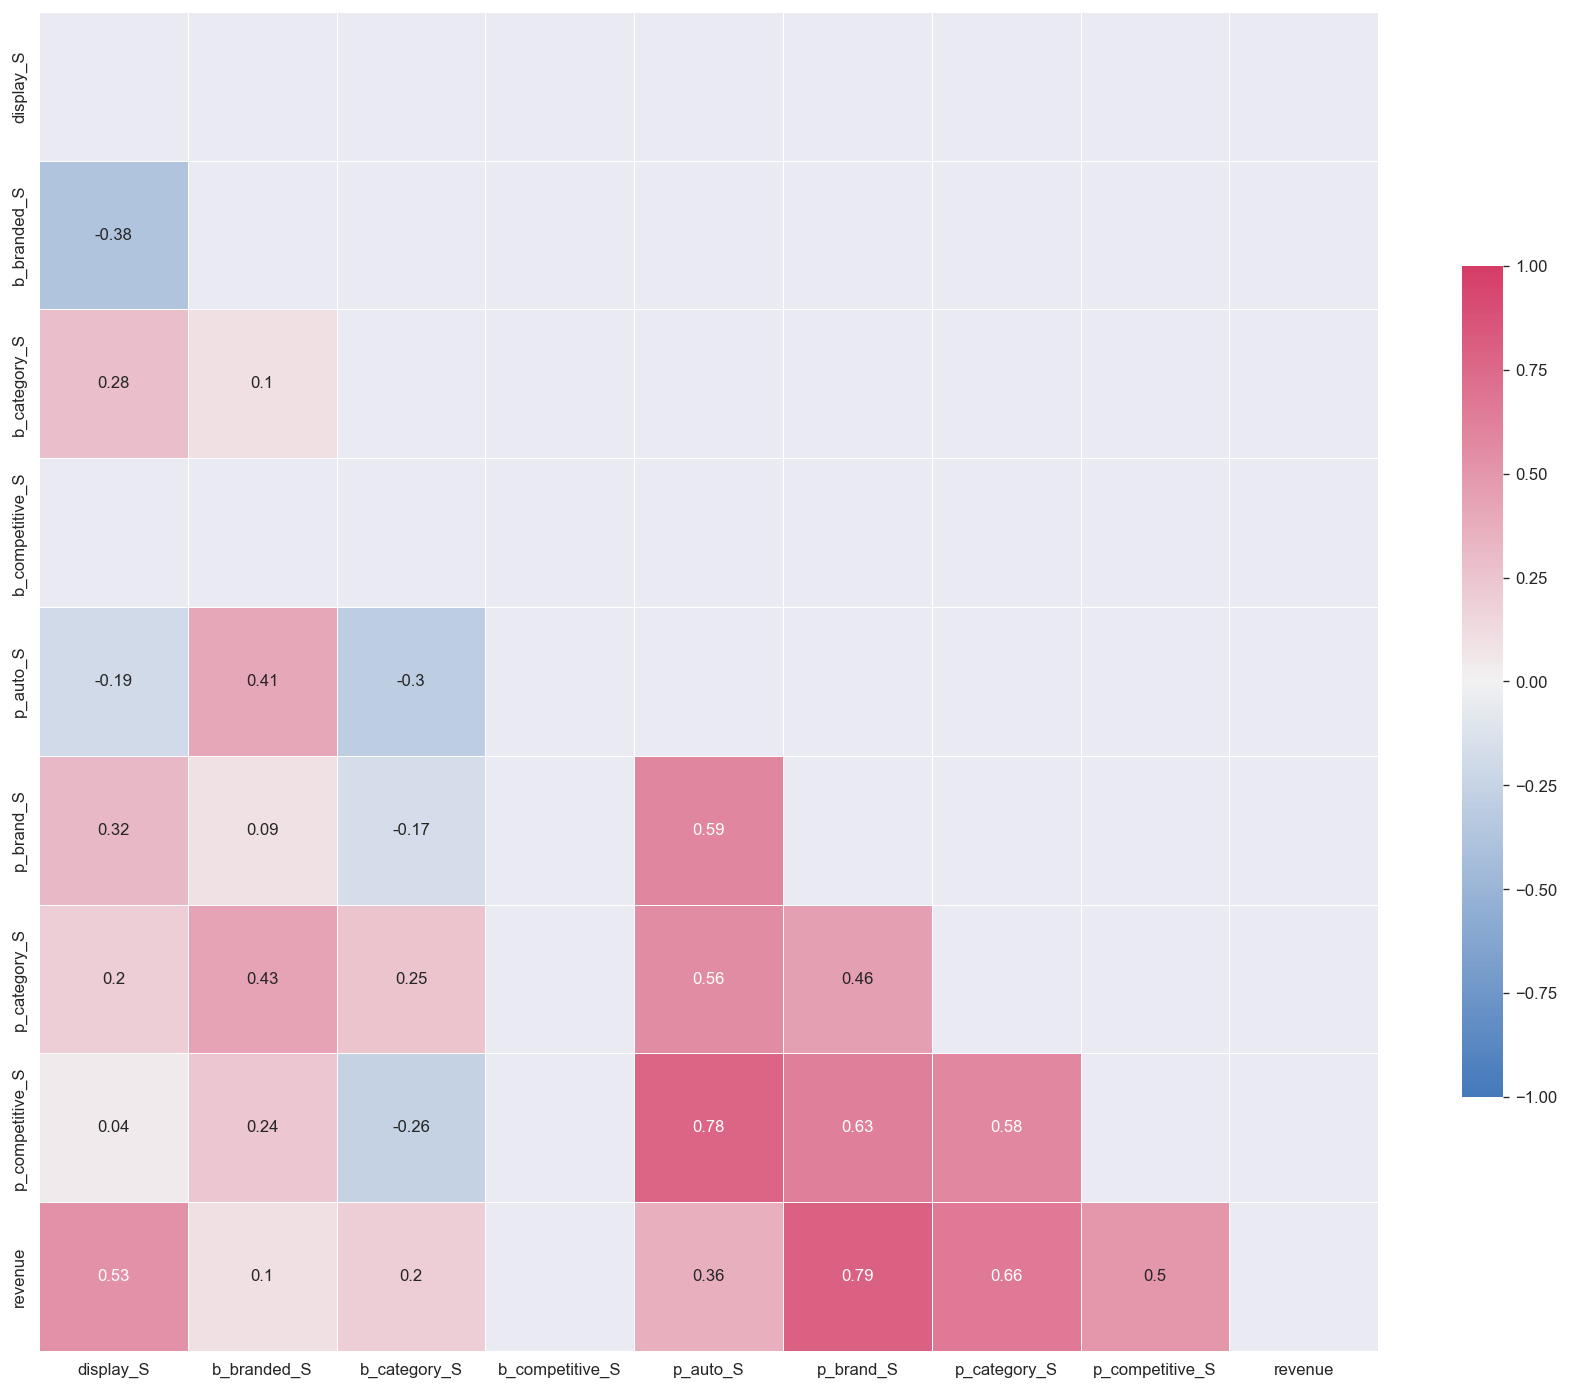

In [20]:
corr = df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

With so many more duplicated y values, looking through the data it shows that for the same date the revenue is replicated several times over. Here I group by dates and take the average of the revenue to have a single value for revenue per date value.

In [ ]:
df_a = df.groupby('ds').apply('y').mean().reset_index()
print('Missing Values')
print(df_a['y'].isnull().sum() / len(df_a) * 100)
print('Zeroes')
print((df_a['y'] == 0).sum())

This is something we had to do when modeling Tyson originally, but we have to drop all of the NA's, which is about 30,000 original observations.

In [ ]:
df_a= df.dropna()

The date values aren't daily; they skip a day here or there, so I decided to group them into weeks.

In [ ]:
df_a['date'] = pd.to_datetime(df_a['ds']) - pd.to_timedelta(7, unit='d')
weekly = df_a.groupby([pd.Grouper(key='date', freq='W')])['y'].sum().reset_index()
weekly = weekly.rename(columns={'y': 'revenue'})

In [ ]:
print('Missing Values')
print(weekly['revenue'].isnull().sum() / len(weekly) * 100)
print('Zeroes')
print((weekly['revenue'] == 0).sum())

Still seven weeks at zero, so they have to be dropped for future methods.

In [ ]:
weekly = weekly[weekly.revenue != 0]

In [ ]:
print('Missing Values')
print(weekly['revenue'].isnull().sum() / len(weekly) * 100)
print('Zeroes')
print((weekly['revenue'] == 0).sum())

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(weekly, weekly['date'], weekly['revenue'], title='Sales Over Time')

The plot shows massive spikes and is wildly inconsistent. It appears that from the minimum to the maximum is five orders of magnitude.

In [ ]:
weekly['revenue'].describe()

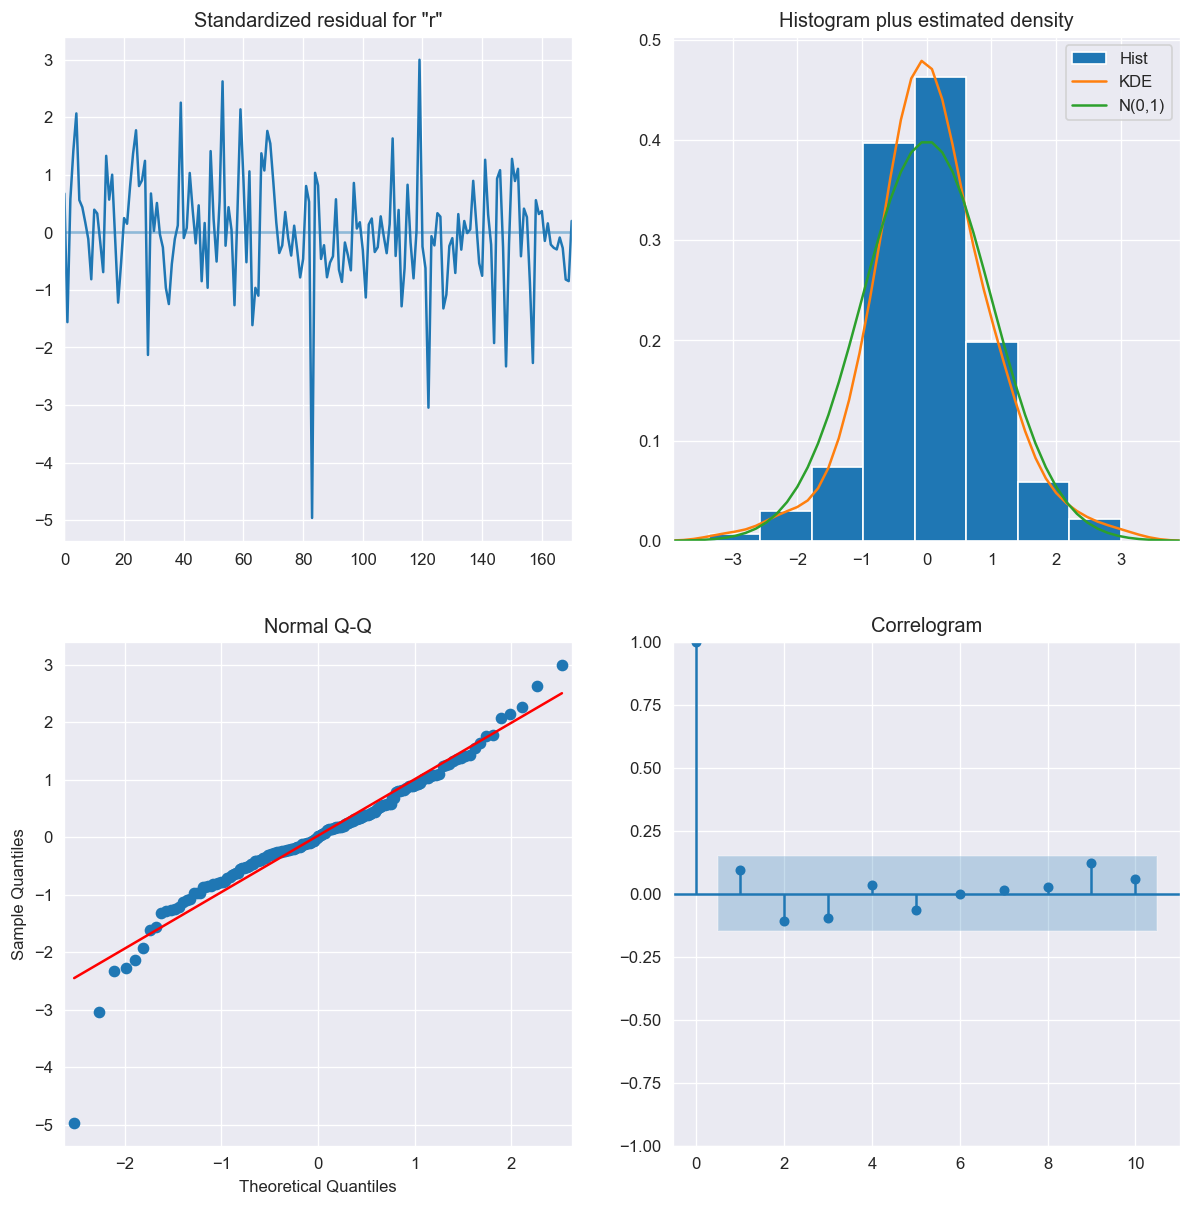

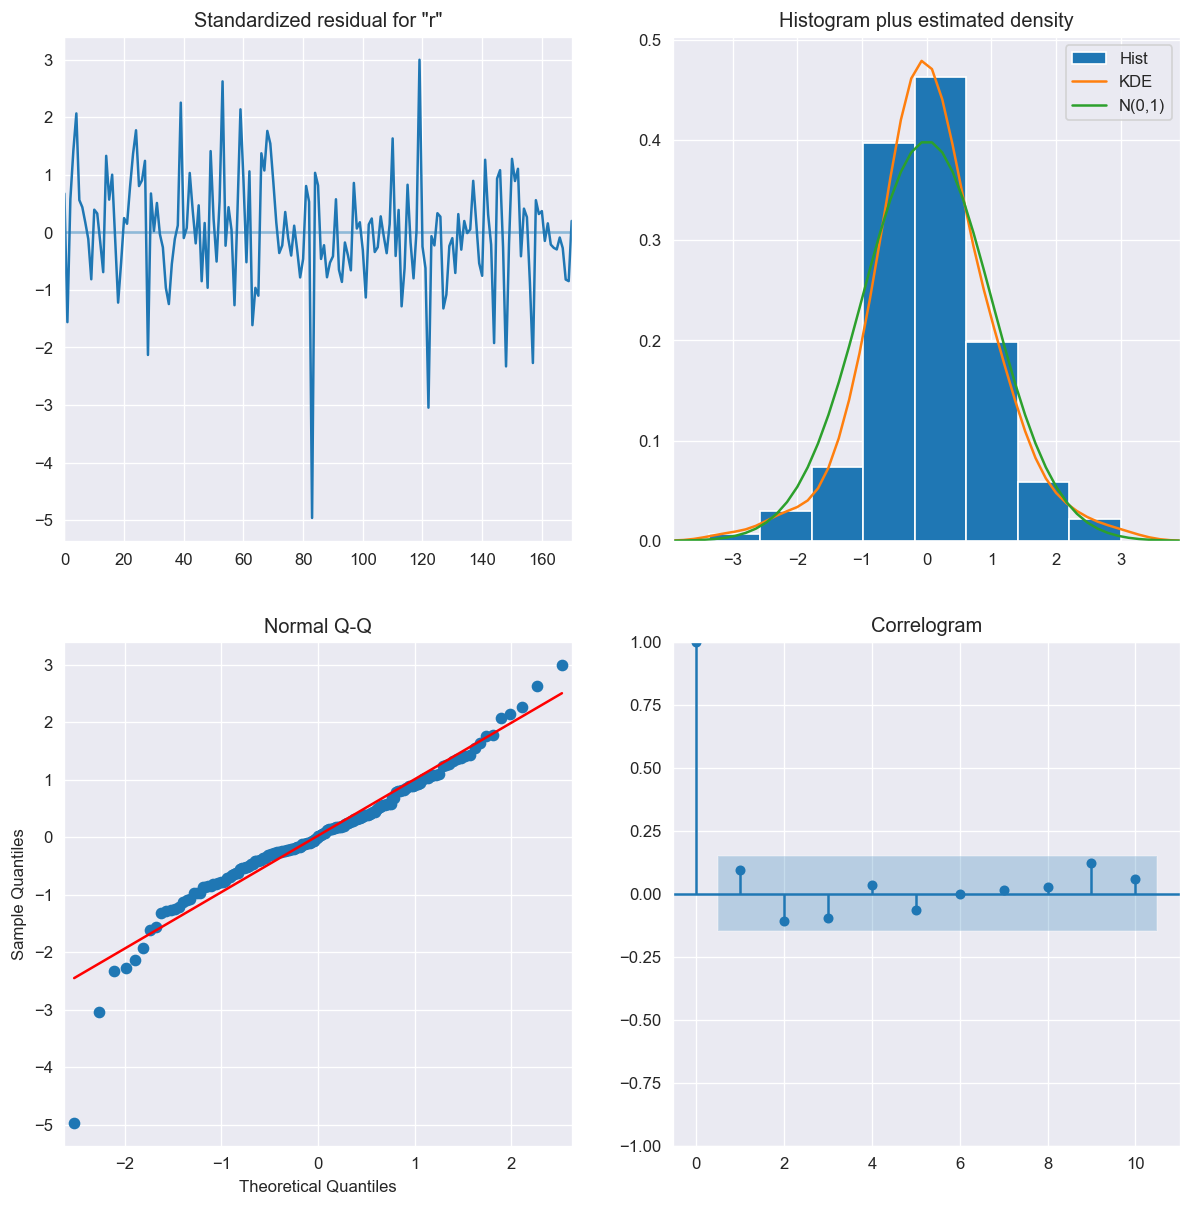

C:\Users\norri\anaconda3\envs\workspace\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


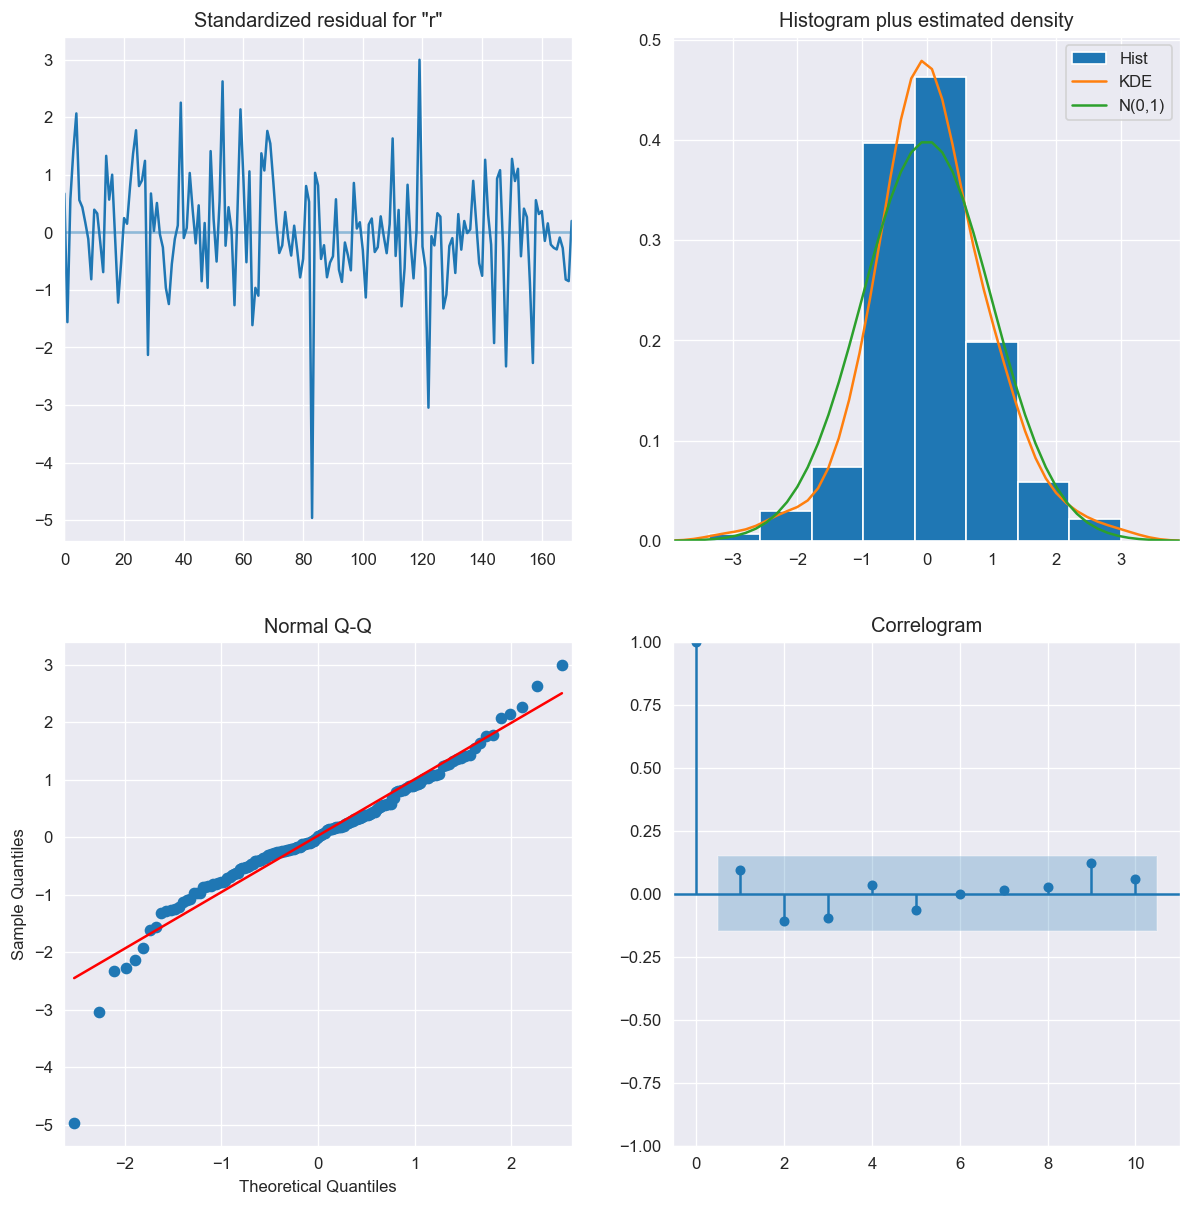

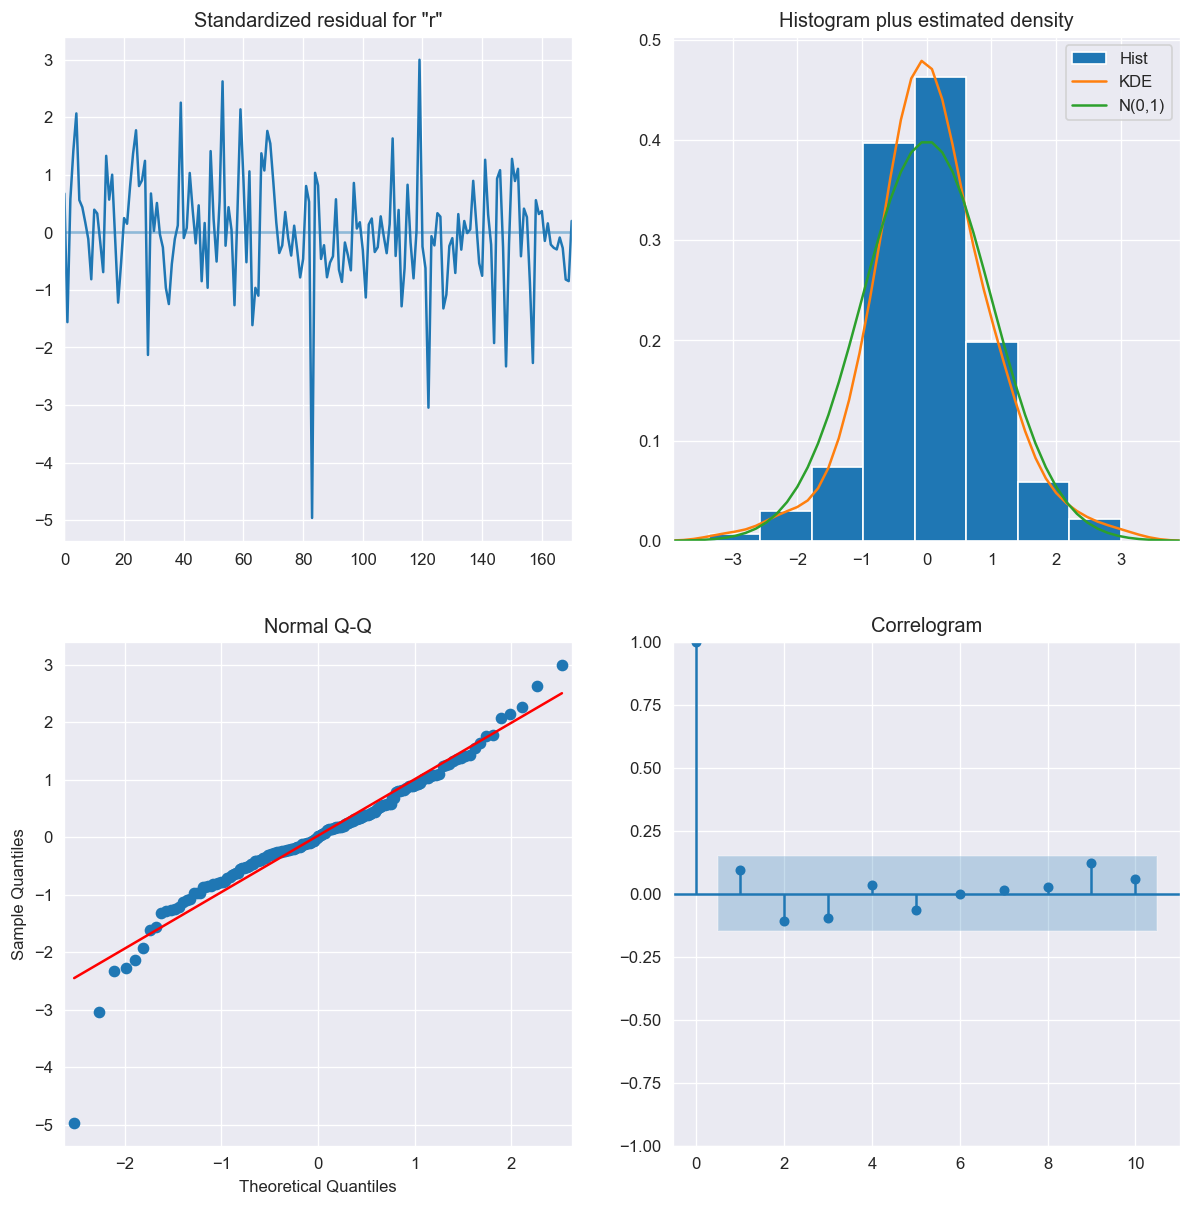

In [22]:
mod = sm.tsa.statespace.SARIMAX(df['revenue'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
results.plot_diagnostics(figsize=(12, 12))

THe Q-Q plots show that ARIMA is fitting very poorly here. The following autocorrelation plot is not great, but not terrible. Still with the uncertainty the data is showing, it is hard to trust it.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

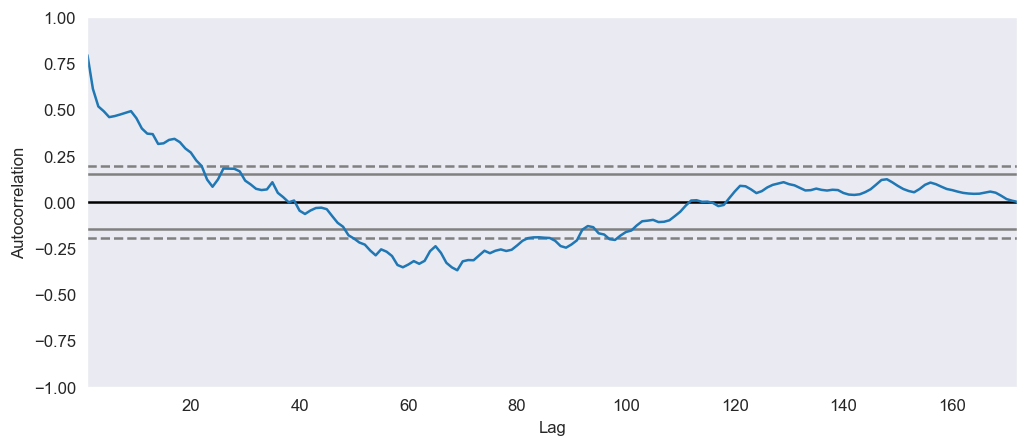

In [23]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['revenue'].tolist())

I'll give auto ARIMA a chance to perfect the parameters to see if it's any better.

In [9]:
train = df['revenue']
mod_auto_arima = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,
                         max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3916.228, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3884.146, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3848.612, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3915.632, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3850.530, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3850.495, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3883.118, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3852.578, Time=0.73 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3836.473, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3893.617, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3838.400, Time=0.30 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3865.611, Time=0.27 sec
 ARIMA(1,1,1)(1,1,2)[12]     

In [ ]:
train = weekly['revenue'][-12:]
test = weekly['revenue'][:12].reset_index() # missing pass sixteen weeks
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = mod_auto_arima.predict(n_periods=12)
fcst = pd.DataFrame(columns = ['forecast', 'test'])
fcst['forecast'] = forecast
fcst = fcst.reset_index()
fcst['test'] = test['revenue']

It's a truly terrible forecast. The 80 preceding values had no real capability of predicting the following twelve.

In [ ]:
plt.plot(fcst['forecast'], label='Forecast')
plt.plot(fcst['test'], label='Actuals')
leg = plt.legend()
plt.show()